# Perceptron 
All the codes are executed with tensorflow 2.7.

## Dataset

In [18]:
##########################
### DATASET
##########################

import numpy as np

data = np.genfromtxt('data/perceptron_toydata.txt', delimiter='\t')
X, y = data[:, :2], data[:, 2]
y = y.astype(int)

In [19]:
print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


In [20]:
# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

In [21]:
# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

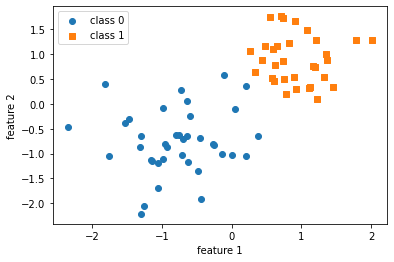

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

## Load and prepare the dataset
You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data

In [28]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.7.0


In [32]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [35]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


## Build a model
Build a tf.keras.Sequential model by stacking layers.

In [36]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

The model returns a vector of logits or log-odds scores, one for each class.

In [39]:
x_train[:1].shape

(1, 28, 28)

In [37]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.7218959 ,  0.18987444,  0.25769615, -0.06217983,  0.7649374 ,
        -0.2182465 ,  0.2276623 ,  0.50609684,  0.25694516, -0.2643575 ]],
      dtype=float32)

The tf.nn.softmax function converts these logits to probabilities for each class:

In [40]:
tf.nn.softmax(predictions).numpy()

array([[0.15327497, 0.09003621, 0.09635447, 0.06997638, 0.1600162 ,
        0.05986494, 0.09350359, 0.12352388, 0.09628213, 0.05716719]],
      dtype=float32)

Note: It is possible to bake the tf.nn.softmax function into the activation function for the last layer of the network. While this can make the model output more directly interpretable, this approach is discouraged as it's impossible to provide an exact and numerically stable loss calculation for all models when using a softmax output.

Define a loss function for training using `losses.SparseCategoricalCrossentropy`, which takes a vector of logits and a `True` index and returns a scalar loss for each example.

In [42]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
print(loss_fn)

This loss is equal to the negative log probability of the true class: The loss is zero if the model is sure of the correct class.

This untrained model gives probabilities close to random (1/10 for each class), so the initial loss should be close to `-tf.math.log(1/10) ~= 2.3`.

In [43]:
loss_fn(y_train[:1], predictions).numpy()

2.8156643

Before you start training, configure and compile the model using Keras `Model.compile`. Set the [`optimizer`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers) class to `adam`, set the `loss` to the `loss_fn` function you defined earlier, and specify a metric to be evaluated for the model by setting the `metrics` parameter to `accuracy`.

In [44]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

## Train and evaluate your model

Use the `Model.fit` method to adjust your model parameters and minimize the loss: 

In [48]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
 101/1875 [>.............................] - ETA: 1s - loss: 0.0708 - accuracy: 0.9802

2021-11-11 22:22:18.018016: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.


1875/1875 [==============================] - 2s 953us/step - loss: 0.0658 - accuracy: 0.9794
Epoch 2/5
1875/1875 [==============================] - 2s 950us/step - loss: 0.0571 - accuracy: 0.9820
Epoch 3/5
1875/1875 [==============================] - 2s 951us/step - loss: 0.0530 - accuracy: 0.9826
Epoch 4/5
1875/1875 [==============================] - 2s 957us/step - loss: 0.0478 - accuracy: 0.9842
Epoch 5/5
1875/1875 [==============================] - 2s 955us/step - loss: 0.0434 - accuracy: 0.9851


The `Model.evaluate` method checks the models performance, usually on a "[Validation-set](https://developers.google.com/machine-learning/glossary#validation-set)" or "[Test-set](https://developers.google.com/machine-learning/glossary#test-set)".

In [49]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0679 - accuracy: 0.9803 - 229ms/epoch - 731us/step


[0.06790845096111298, 0.9803000092506409]

If you want your model to return a probability, you can wrap the trained model, and attach the softmax to it:

In [50]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [51]:
probability_model(x_test[:5])

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[2.3937292e-09, 1.1973583e-11, 1.2198935e-06, 3.4822198e-04,
        5.6879338e-15, 5.9756665e-08, 8.2357098e-15, 9.9965000e-01,
        6.0029999e-09, 4.9886933e-07],
       [1.4737110e-07, 5.6868089e-07, 9.9999845e-01, 7.6511833e-07,
        3.1036892e-19, 1.2239698e-07, 4.6262123e-08, 5.3104400e-18,
        3.0698068e-08, 2.4005009e-15],
       [8.7680346e-10, 9.9977297e-01, 4.0986673e-05, 3.6480591e-07,
        5.8045271e-06, 2.5003223e-08, 1.4228743e-06, 1.4534946e-04,
        3.3163386e-05, 3.7209507e-09],
       [9.9993253e-01, 5.1017892e-13, 2.5395789e-06, 3.8548471e-09,
        2.0010750e-08, 3.5037849e-07, 5.4873140e-05, 1.6970235e-07,
        1.8226973e-13, 9.5594060e-06],
       [2.0013066e-07, 1.1023188e-13, 3.1103813e-08, 7.4306086e-09,
        9.6991283e-01, 1.3392252e-06, 4.2032698e-07, 1.6571110e-05,
        3.1266418e-09, 3.0068612e-02]], dtype=float32)>

In [25]:
import tensorflow as tf
#from tensorflow.examples.tutorials.mnist import input_data

ModuleNotFoundError: No module named 'tensorflow.examples'

In [27]:
##########################
### SETTINGS
##########################

# Architecture
n_features = X.shape[1]
print("No. of features ",n_features)

No. of features  2
